In [1]:
# import necessary modules
import os
from pathlib import Path
import sys
import shutil
#import numpy as np
import pandas as pd
import geopandas as gpd
#from matplotlib import path
#import time
import xarray as xr
from datetime import datetime

# Undo below code and specify your folder if you don't run this code under hydromt_sfincs_insider github branch
#sys.path.append(os.path.abspath("C:/Intern/SFINCS_Wave/hydromt_sfincs_insiders")) 
sys.path.append(os.path.abspath("../../hydromt_sfincs_insiders")) 

from hydromt_sfincs.sfincs import SfincsModel
#from hydromt_sfincs import utils
from hydromt.log import setuplog
import hydromt

**1. Model Initialization**
 
1.1. Ensuring updated HydroMT version

In [2]:
!hydromt --version

HydroMT version: 0.10.0


1.2. Initialize SFINCS Model and Connect It with Data Catalog

In [ ]:
# Specify folders
root_folder  = Path('sofala_wave_v7')
boundary_folder = Path('boundary_conditions')

# specify which method of snapwave input will be used (ascii or .nc file)
snapwave_ascii = True

In [4]:
# Specify logger_name
logger = setuplog("sfincs_quadtree", log_level=10)

# initialize model
sf_qt = SfincsModel(
    data_libs = ['datacatalog_vNatalia.yml'], 
    root=root_folder, 
    mode="w+", 
    logger=logger
)

2024-11-06 16:58:30,087 - sfincs_quadtree - log - INFO - HydroMT version: 0.10.0
2024-11-06 16:58:30,197 - sfincs_quadtree - data_catalog - INFO - Parsing data catalog from datacatalog_vNatalia.yml
2024-11-06 16:58:30,230 - sfincs_quadtree - log - DEBUG - Writing log messages to new file c:\Users\aleksand\git_projects\COMPASS\SFINCS_Wave\sofala_wave_v7\hydromt.log.
2024-11-06 16:58:30,232 - sfincs_quadtree - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.1.0).


Rerun below code if you update your data catalog

In [5]:
#data_catalog  = hydromt.DataCatalog(data_libs = ['datacatalog.yml'])
data_catalog  = hydromt.DataCatalog(data_libs = ['datacatalog_vNatalia.yml'])

**2.Setup Quadtree Grid, Dep, and Mask**
 
2.1. Import region and refinement polygon

In [6]:
epsg = 32736
quadtree_region = gpd.read_file(boundary_folder / 'gis' / 'bbox_new.gpkg').to_crs(epsg)
quadtree_refinement = gpd.read_file(boundary_folder / 'gis' / 'refinement_v2.gpkg').to_crs(epsg)

gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1]},
    geometry=[
        quadtree_refinement.geometry.iloc[0]
    ],
    crs=f'EPSG:{epsg}'
)

In [7]:
quadtree_region.geometry.values

<GeometryArray>
[<POLYGON ((631685.149 7799834.991, 714984.688 7728034.47, 798296.376 7832687...>]
Length: 1, dtype: geometry

<Axes: >

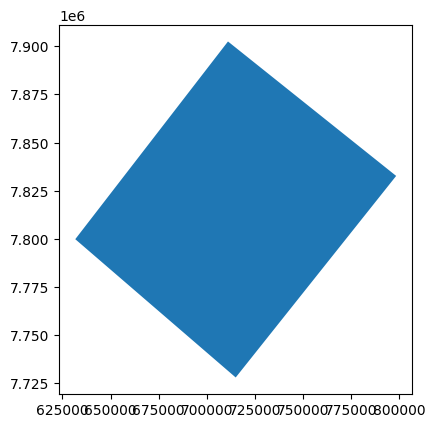

In [8]:
quadtree_region.plot()

<Axes: >

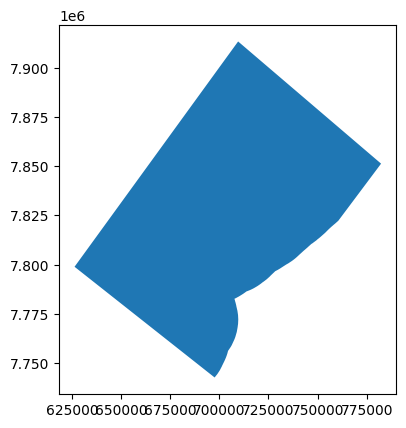

In [9]:
gdf_refinement.plot()

2.2. Making grid

2024-11-06 16:58:33,110 - sfincs_quadtree - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [ 631685.14925612 7728034.47010683  798296.37619914 7902490.16739193] (crs = EPSG:32736)'}
Building mesh ...
Refining ...
Time elapsed : 4.0109946727752686 s
Finding neighbors ...
Time elapsed : 0.8029391765594482 s
Setting neighbors left and below ...
Time elapsed : 2.3532485961914062 s
Getting uv points ...
Time elapsed : 3.056370973587036 s
Making XUGrid ...
Got rid of duplicates in 18.4426 seconds
Made XUGrid in 0.0819 seconds
Time elapsed : 47.83051085472107 s


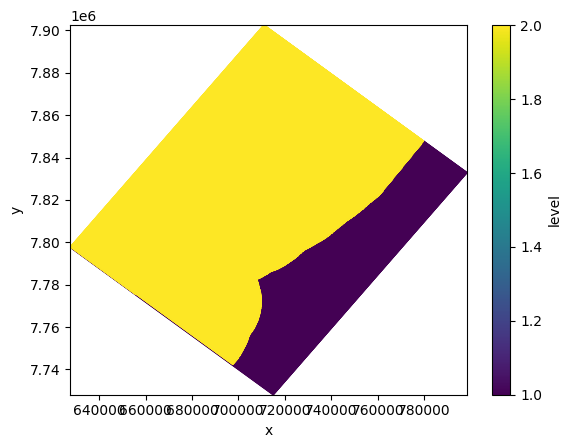

In [10]:
sf_qt.setup_grid_from_region(
    region={"geom": quadtree_region},  
    res=200,  
    rotated=True, 
    refinement_polygons=gdf_refinement,
)


sf_qt.quadtree.data["level"].ugrid.plot()

2.3. Setup dep

In [11]:
datasets_dep = [{'elevtn': 'gebco'}]
sf_qt.setup_dep(datasets_dep=datasets_dep)

2024-11-06 17:00:04,141 - sfincs_quadtree - rasterdataset - INFO - Reading gebco raster data from c:\Users\aleksand\git_projects\COMPASS\SFINCS_Wave\boundary_conditions\topo\gebco_2024_n-13.0_s-25.0_w30.0_e45.0.nc
2024-11-06 17:00:04,391 - sfincs_quadtree - rasterdataset - WARNING - IO error while detecting zoom levels: Opening a /vsi file with the netCDF driver requires Linux userfaultfd to be available.
2024-11-06 17:00:04,913 - sfincs_quadtree - rasterdataset - DEBUG - Clip to [34.218, -20.534, 35.845, -18.959] (epsg:4326))


2.4. Setup Quadtree Mask and WL Boundary

<Axes: >

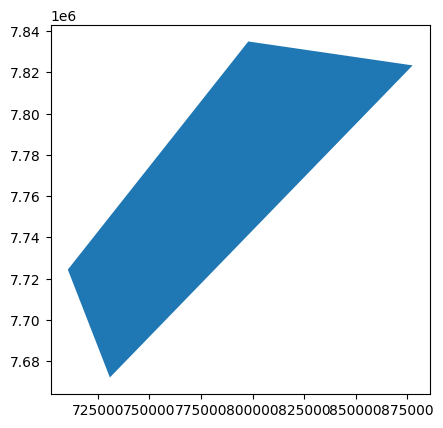

In [12]:
# Import WL and Wave Boundary polygon
open_include = gpd.read_file(boundary_folder / 'gis' / 'open_sea_v2.gpkg').to_crs(epsg)
open_include = open_include.to_crs(epsg=epsg)
open_include.plot()

2024-11-06 17:00:11,501 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [34.258, -20.534, 35.843, -18.959] (EPSG:4326)


2024-11-06 17:00:11,518 - sfincs_quadtree - quadtree - INFO - Building mask ...
2024-11-06 17:00:11,519 - sfincs_quadtree - quadtree - INFO - Build new mask for: sfincs ...
2024-11-06 17:00:21,722 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [34.218, -20.534, 35.845, -18.959] (EPSG:4326)
2024-11-06 17:00:21,750 - sfincs_quadtree - quadtree - DEBUG - waterlevel (mask=2) boundary cells reset.


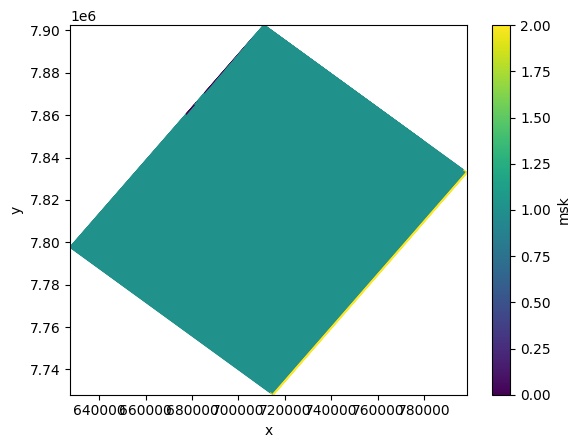

In [13]:
sf_qt.setup_mask_active(
    include_mask=sf_qt.region,
    zmin=-99,
    zmax=111,
    reset_mask=True
)

sf_qt.setup_mask_bounds(
    btype="waterlevel",
    include_mask=open_include,
    zmax=-5,
    reset_bounds=True
)

sf_qt.quadtree.data["msk"].ugrid.plot()

**3.Setup Snapwave Functionality**
 
3.1. Setup Snapwave Mask & Boundary Line

2024-11-06 17:00:50,275 - sfincs_quadtree - quadtree - INFO - Building mask ...
2024-11-06 17:00:50,276 - sfincs_quadtree - quadtree - INFO - Build new mask for: snapwave ...
2024-11-06 17:00:52,500 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [34.218, -20.534, 35.845, -18.959] (EPSG:4326)


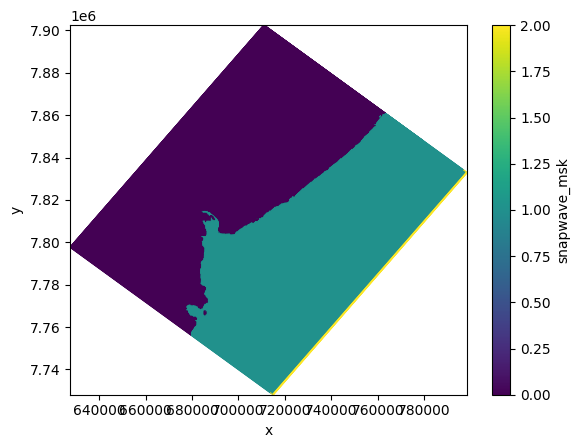

In [14]:
sf_qt.setup_mask_active(
    model="snapwave",
    zmax=0,
    zmin=-999,
    reset_mask=True
)

sf_qt.setup_mask_bounds(
    model="snapwave",    
    include_mask=open_include,
    copy_sfincsmask=False
)

fig = sf_qt.quadtree.data["snapwave_msk"].ugrid.plot()

**4. Input Forcing and Specify Observation Points**

4.1. Specify time

In [15]:
# Specify the simulation time in the model config
model_time_config = {
    "tref": "20190313 000000", #FILL IN THE REFERENCE TIME (can be any date)
    "tstart": "20190313 000000", #FILL IN THE START TIME OF THE SIMULATION
    "tstop": "20190316 000000", #FILL IN THE END TIME OF THE SIMULATION
    "dtout": 3600, #FILL IN THE TIMESTEP OF THE MAP OUTPUT
    "dthisout" : 3600, #FILL IN THE TIMESTEP OF THE SCALAR OUTPUT
}

sf_qt.setup_config(**model_time_config)
sf_qt.config["tspinup"] = 3600

2024-11-06 17:01:19,841 - sfincs_quadtree - model_api - DEBUG - Setting model config options.


4.2. Specify WL from DFM and Meteo from ERA5

In [16]:
sf_qt.setup_waterlevel_forcing(
    geodataset='dfm_output_wl_open',   
    buffer=20000
)

sf_qt.setup_wind_forcing_from_grid(
    wind = 'era5_hourly'
)

sf_qt.setup_pressure_forcing_from_grid(
    press='era5_hourly'
)

2024-11-06 17:01:22,050 - sfincs_quadtree - rasterdataset - INFO - Reading era5_hourly netcdf data from c:\Users\aleksand\git_projects\COMPASS\SFINCS_Wave\boundary_conditions\meteo\era5_{variable}_2019-03.nc
2024-11-06 17:01:22,118 - sfincs_quadtree - rasterdataset - DEBUG - Slicing time dim (datetime.datetime(2019, 3, 13, 0, 0), datetime.datetime(2019, 3, 16, 0, 0))
2024-11-06 17:01:22,141 - sfincs_quadtree - rasterdataset - DEBUG - Clip to [34.258, -20.534, 35.843, -18.959] (epsg:4326))
2024-11-06 17:01:22,147 - sfincs_quadtree - sfincs - DEBUG - Resample wind using nearest_index.
2024-11-06 17:01:22,856 - sfincs_quadtree - rasterdataset - INFO - Reading era5_hourly netcdf data from c:\Users\aleksand\git_projects\COMPASS\SFINCS_Wave\boundary_conditions\meteo\era5_{variable}_2019-03.nc
2024-11-06 17:01:22,895 - sfincs_quadtree - rasterdataset - DEBUG - Slicing time dim (datetime.datetime(2019, 3, 13, 0, 0), datetime.datetime(2019, 3, 16, 0, 0))
2024-11-06 17:01:22,905 - sfincs_quadtre

4.3. Specify SPW Input

In [17]:
# Specify spw file location
spw_dir = boundary_folder / 'spw'
spw_filename =  "cyclone_option_norain.spw"

# Copy spw file to root folder
source_path = Path(spw_dir) / spw_filename
destination_path = root_folder / spw_filename
shutil.copy(source_path, destination_path)
print(f"File copied to: {destination_path}")

# Modify sfincs.inp to include spw
sf_qt.config["spwfile"] = spw_filename
sf_qt.config["utmzone"] = '36s'

File copied to: sofala_wave_v7\cyclone_option_norain.spw


4.4. Specify Wave Boundary Forcing

In [18]:
# ERA5_wave_filepath = boundary_folder / "wave" / "era5_wave_preprocessed.nc"
# ERA5_wave = xr.open_dataset(ERA5_wave_filepath)
# sf_qt.setup_wave_forcing(
#     geodataset=ERA5_wave
# )

In [19]:
ERA5_wave_filepath = boundary_folder / "wave" / "era5_wave_new.nc"
ERA5_wave = xr.open_dataset(ERA5_wave_filepath)

In [20]:
from shapely.geometry import Point
df = pd.DataFrame(
    {'Latitude': ERA5_wave.y.values.tolist(),
     'Longitude': ERA5_wave.x.values.tolist()})

df['Geometry'] = list(zip(df.Longitude, df.Latitude))
df = df.drop(['Latitude','Longitude'],axis=1)
df['Geometry'] = df['Geometry'].apply(Point)

gdf = gpd.GeoDataFrame(df,geometry='Geometry',crs=ERA5_wave.crs)

In [21]:
ERA5_wave.load()

<xarray.Dataset> Size: 5kB
Dimensions:      (time: 96, index: 2)
Coordinates:
    x            (index) float64 16B 7.894e+05 7.357e+05
    y            (index) float64 16B 7.831e+06 7.777e+06
    expver       (time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001' '0001'
    number       int64 8B 0
  * time         (time) datetime64[ns] 768B 2019-03-13 ... 2019-03-16T23:00:00
    spatial_ref  int32 4B 0
Dimensions without coordinates: index
Data variables:
    wd           (time, index) float32 768B 145.6 130.1 146.6 ... 119.6 111.9
    tp           (time, index) float32 768B 7.076 7.253 7.097 ... 5.366 5.245
    hs           (time, index) float32 768B 2.131 1.957 2.168 ... 1.277 1.317
    ds           (time, index) float32 768B 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-24T15:14 GRIB to CDM+CF via cfgrib-0.9.1...
    crs:                     EPSG:32736

In [ ]:
if snapwave_ascii:
    hs = ERA5_wave['hs'].values.tolist()
    tp = ERA5_wave['tp'].values.tolist()
    wd = ERA5_wave['wd'].values.tolist()
    ds = ERA5_wave['ds'].values.tolist()
    #time = list(range(0, 3600*len(ERA5_wave.time.values), 3600))

    time = pd.date_range(ERA5_wave.time.values[0], ERA5_wave.time.values[-1], freq='H')


In [ ]:
if snapwave_ascii:
    # get relative time in a dataframe
    t_start = datetime.strptime(sf_qt.config['tstart'],'%Y%m%d %H%M%S')
    tdiff = (time - t_start).total_seconds().to_list()

In [ ]:
if snapwave_ascii:
    # output Hs to .bhs file
    hs_tocsv = pd.DataFrame(hs)
    tmp = pd.DataFrame({'time':tdiff})
    hs_tocsv = pd.concat([tmp,hs_tocsv],axis=1)

    hs_tocsv.to_csv(os.path.join(root_folder,'snapwave.bhs'),index=False,sep=' ',header=False)

In [ ]:
if snapwave_ascii:
    # output wd to .bwd file
    wd_tocsv = pd.DataFrame(wd)
    tmp = pd.DataFrame({'time':tdiff})
    wd_tocsv = pd.concat([tmp,wd_tocsv],axis=1)

    wd_tocsv.to_csv(os.path.join(root_folder,'snapwave.bwd'),index=False,sep=' ',header=False)

In [ ]:
if snapwave_ascii:
    # output Tp to .bhs file
    tp_tocsv = pd.DataFrame(tp)
    tmp = pd.DataFrame({'time':tdiff})
    tp_tocsv = pd.concat([tmp,tp_tocsv],axis=1)

    tp_tocsv.to_csv(os.path.join(root_folder,'snapwave.btp'),index=False,sep=' ',header=False)

In [ ]:
if snapwave_ascii:
    # output ds to .bhs file
    ds_tocsv = pd.DataFrame(ds)
    tmp = pd.DataFrame({'time':tdiff})
    ds_tocsv = pd.concat([tmp,ds_tocsv],axis=1)

    ds_tocsv.to_csv(os.path.join(root_folder,'snapwave.bds'),index=False,sep=' ',header=False)

In [ ]:
if snapwave_ascii:
    # output snapwave bnd file
    bnd_coords = pd.DataFrame({'x':ERA5_wave.x.values,'y':ERA5_wave.y.values})
    bnd_coords.to_csv(os.path.join(root_folder,'snapwave.bnd'),index=False,sep=' ',header=False)

In [29]:
# df_hs = pd.DataFrame(index=time, data=hs)
# df_tp = pd.DataFrame(index=time, data=tp)
# df_wd = pd.DataFrame(index=time, data=wd)
# df_ds = pd.DataFrame(index=time, data=ds)

# list_df = [df_hs, df_tp, df_wd, df_ds]
# sf_qt.setup_wave_forcing(timeseries=list_df, locations=gdf)

In [ ]:
if not snapwave_ascii:
    ERA5_wave = ERA5_wave.rename({'index':'stations'})
    sf_qt.setup_wave_forcing(geodataset=ERA5_wave)

Below: Using the same approach as in MakeDuck by Tim

In [30]:
# import xarray as xr
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point
# from scipy.spatial import cKDTree

# # Load ERA5 dataset
# era5_path = r"C:\Intern\SFINCS_Wave\COMPASS\SFINCS_Wave\boundary_conditions\wave\era5_wave_preprocessed.nc"
# era5new = xr.open_dataset(era5_path)

# # Extract original time and required variables from ERA5 dataset
# time = pd.to_datetime(era5new.time.values)  # Original ERA5 time values
# hs_values = era5new["hs"].values
# tp_values = era5new["tp"].values
# dir_values = era5new["wd"].values
# ds_values = era5new["ds"].values

# # ERA5 grid locations
# era5_lats = era5new["x"].values
# era5_lons = era5new["y"].values

# # Convert ERA5 grid locations to a 2D list of coordinates
# era5_coords = list(zip(era5_lons, era5_lats))

# # Load custom points GeoDataFrame from Quadtree Mask file
# points_filepath = r"C:\Intern\SFINCS_Sofala\boundary_conditions\Quadtree_Mask\ERA5_wave_bnd.gpkg"
# points_gdf = gpd.read_file(points_filepath)

# # Ensure both GeoDataFrames use the same CRS
# points_gdf = points_gdf.to_crs("EPSG:4326")

# # Extract lat/lon from points_gdf to match nearest points in ERA5 grid
# points_coords = [(point.x, point.y) for point in points_gdf.geometry]

# # Use cKDTree for efficient nearest-neighbor search
# tree = cKDTree(era5_coords)
# distances, indices = tree.query(points_coords)  # Find nearest ERA5 grid point for each custom point

# # Adjust index_values to start from 1 instead of 0
# index_values = range(1, len(points_coords) + 1)  # Start index from 1

# # Create DataFrames directly with each location as a column and time as the index
# df_hs = pd.DataFrame(hs_values[:, indices], index=time, columns=index_values)
# df_tp = pd.DataFrame(tp_values[:, indices], index=time, columns=index_values)
# df_dir = pd.DataFrame(dir_values[:, indices], index=time, columns=index_values)
# df_ds = pd.DataFrame(ds_values[:, indices], index=time, columns=index_values)

# # Convert index to MultiIndex with 'time' and 'index' if needed by setup_wave_forcing
# df_hs.index.name = 'time'
# df_tp.index.name = 'time'
# df_dir.index.name = 'time'
# df_ds.index.name = 'time'

# # Store each DataFrame in a list for setup_wave_forcing
# list_df = [df_hs, df_tp, df_dir, df_ds]

In [31]:
# print(list_df)

In [32]:
# points_filepath = boundary_folder / 'wave' / 'ERA5_wave_bnd.gpkg'
# points_gdf = gpd.read_file(points_filepath)

# # Ensure both GeoDataFrames use the same CRS
# points_gdf = points_gdf.to_crs("EPSG:4326")

# sf_qt.setup_wave_forcing(timeseries=list_df, locations=points_gdf)

dict_keys(['bzs', 'wind10_u', 'wind10_v', 'press_2d', 'hs', 'tp', 'wd', 'ds'])


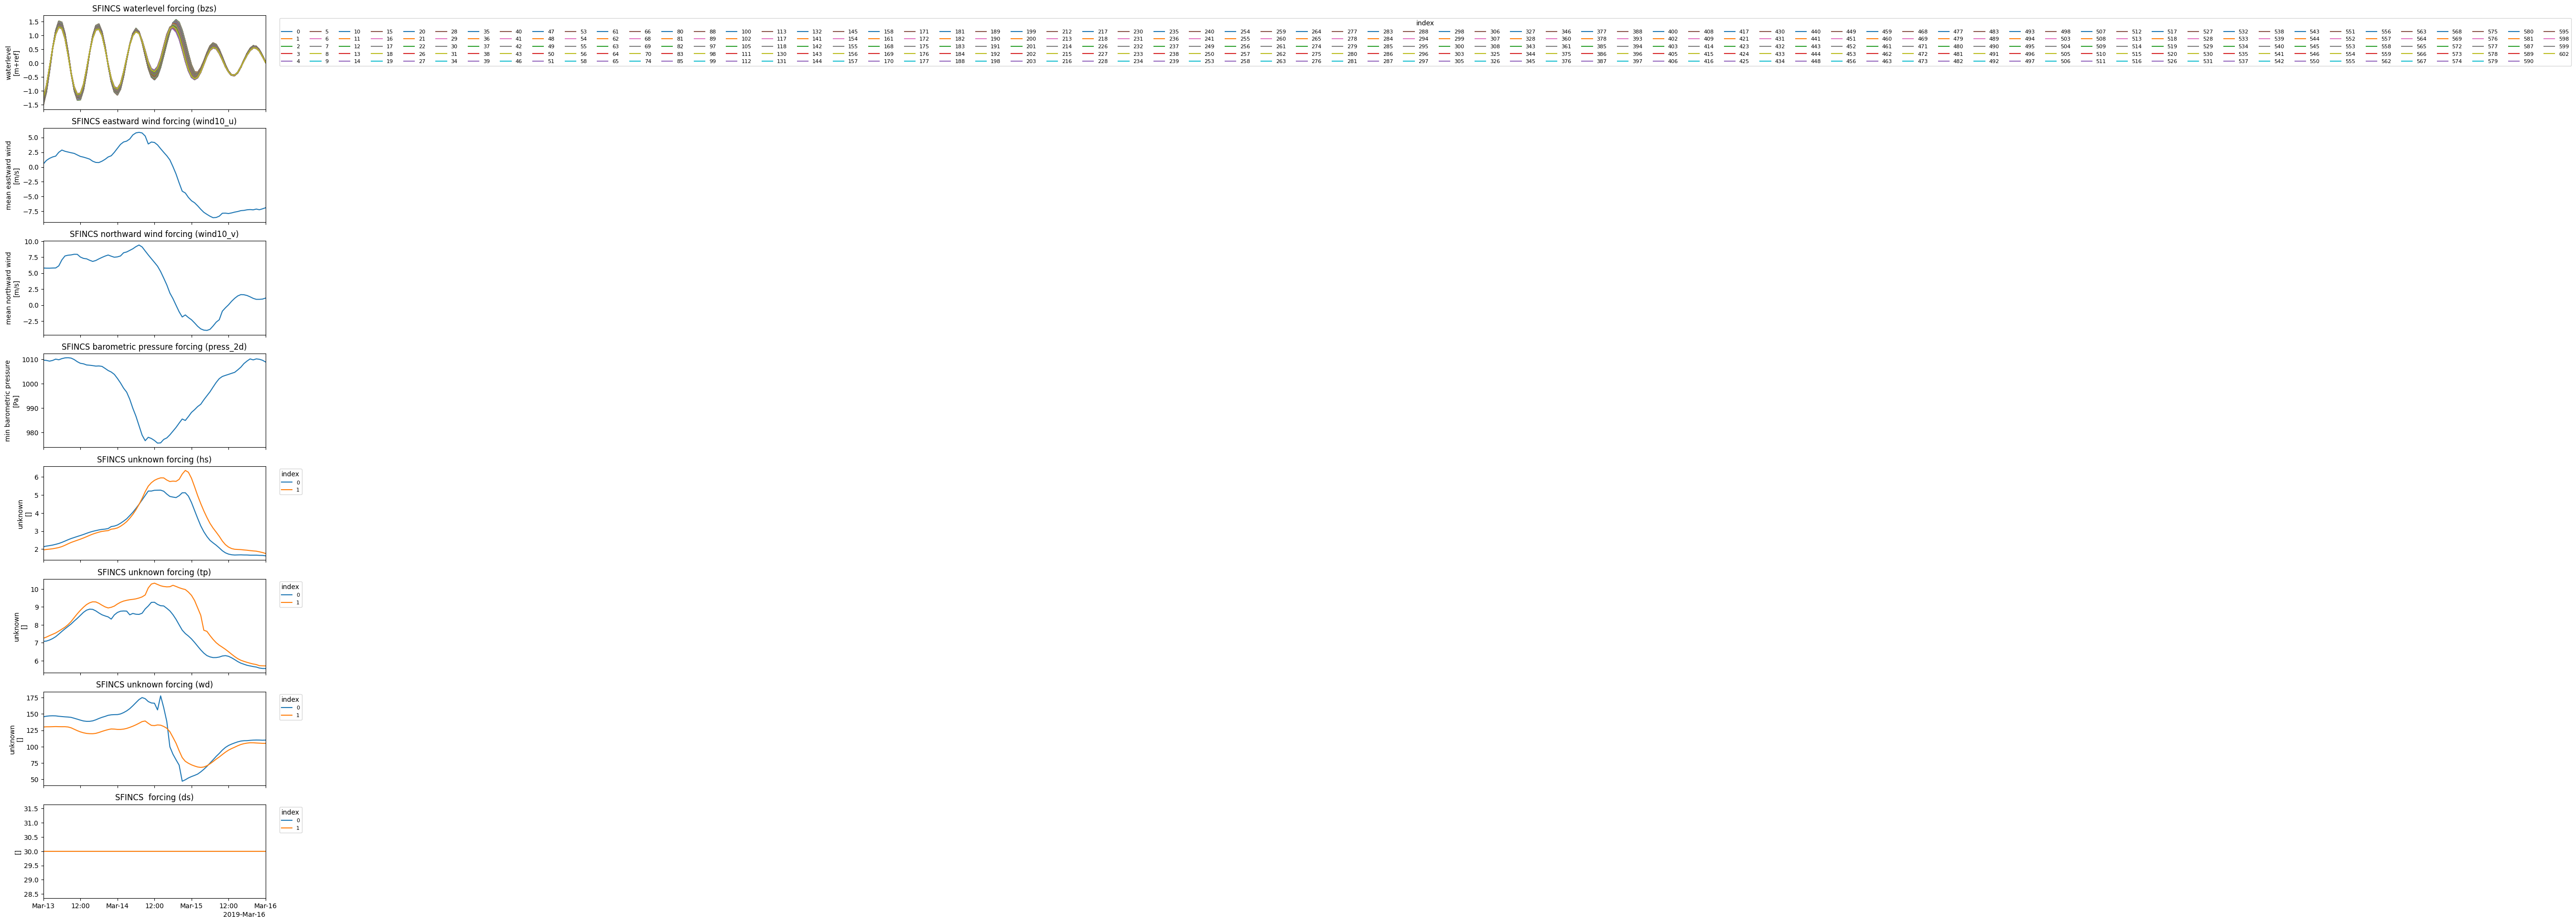

In [25]:
# The keys to access the model forcing
print(sf_qt.forcing.keys())

# # Plot the forcing
_ = sf_qt.plot_forcing()

**5. Wave Maker and Obs Point**

5.1. Setup Obs Point

In [26]:
# Path to observation points & lines geometries
obs_points_fn = boundary_folder / "gis" / 'obs.geojson'

# Setup observation. merge argument handles whether to override or not
sf_qt.setup_observation_points(locations=obs_points_fn, merge=False)

# Print the keys to access the observation geometries
sf_qt.geoms.keys()

2024-11-06 18:59:27,889 - sfincs_quadtree - geodataframe - INFO - Reading  vector data from boundary_conditions\gis\obs.geojson
2024-11-06 18:59:28,130 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [631685.149, 7728034.470, 798296.376, 7902490.167] (EPSG:32736)


dict_keys(['region', 'obs'])

5.2. Setup Wave Maker

In [27]:
wvm = sf_qt.setup_wavemaker(wavemaker=boundary_folder / 'gis' / 'wavemaker.gpkg', merge=False)

sf_qt.geoms.keys()

2024-11-06 18:59:29,073 - sfincs_quadtree - geodataframe - INFO - Reading  vector data from boundary_conditions\gis\wavemaker.gpkg
2024-11-06 18:59:29,161 - sfincs_quadtree - geodataframe - DEBUG - Clip intersects [631685.149, 7728034.470, 798296.376, 7902490.167] (EPSG:32736)


dict_keys(['region', 'obs', 'wvm'])

<Axes: >

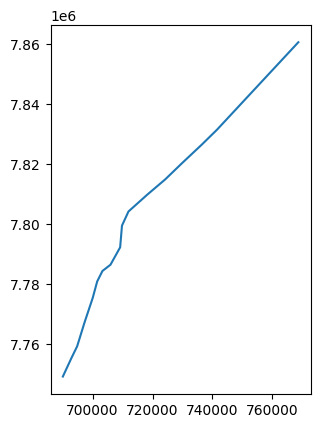

In [28]:
sf_qt.geoms["wvm"].plot()

5.3. SNAPWAVE Config

In [ ]:
sf_qt.config["dtwave"] = 600
sf_qt.config["storefw"] = 1
sf_qt.config["storewavdir"] = 1
sf_qt.config["snapwave"] = 1
sf_qt.config["snapwave_igwaves"] = 1

sf_qt.config["snapwave_shinc2ig"] = 1.0
sf_qt.config["snapwave_fw"] = 0.0001
sf_qt.config["snapwave_fwig"] = 0.015
sf_qt.config["snapwave_baldock_opt"] = 1
sf_qt.config["snapwave_baldock_ratio"] = 0.2
sf_qt.config["snapwave_baldock_ratio_ig"] = 0.2
sf_qt.config["snapwave_alpha"] = 1.5
sf_qt.config["snapwave_alpha_ig"] = 2.5
sf_qt.config["snapwave_gamma"] = 0.78
sf_qt.config["snapwave_gammaig"] = 0.2
sf_qt.config["snapwave_ig_opt"] = 1
sf_qt.config["snapwave_hmin"] = 0.01
sf_qt.config["snapwave_shpercig"] = 1.0
sf_qt.config["snapwave_dtheta"] = 10
sf_qt.config["snapwave_alphaigfac"] = 1.0
sf_qt.config["snapwave_use_herbers"] = 1

if snapwave_ascii:
    # Input files for snapwave setup using ascii files
    sf_qt.config["snapwave_bndfile"]     = 'snapwave.bnd'
    sf_qt.config["snapwave_bhsfile"]     = 'snapwave.bhs'
    sf_qt.config["snapwave_btpfile"]     = 'snapwave.btp'
    sf_qt.config["snapwave_bwdfile"]     = 'snapwave.bwd'
    sf_qt.config["snapwave_bdsfile"]     = 'snapwave.bds'

**6. Finalization and Run SFINCS**

6.1. Write Model

In [30]:
sf_qt.write()

2024-11-06 18:59:33,892 - sfincs_quadtree - sfincs - INFO - Writing model data to c:\Users\aleksand\git_projects\COMPASS\SFINCS_Wave\sofala_wave_v7


2024-11-06 18:59:36,724 - sfincs_quadtree - sfincs - INFO - Write geom files
2024-11-06 18:59:36,800 - sfincs_quadtree - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2024-11-06 18:59:36,922 - sfincs_quadtree - sfincs - INFO - Write forcing files
2024-11-06 18:59:37,012 - sfincs_quadtree - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2024-11-06 18:59:37,653 - sfincs_quadtree - sfincs - INFO - Write vector file(s) for forcing.hs to 'gis' subfolder
2024-11-06 18:59:37,697 - sfincs_quadtree - sfincs - DEBUG - Variable forcing.hs could not be written to vector file.
2024-11-06 18:59:37,715 - sfincs_quadtree - sfincs - WARNING - zsini not in states, skipping


In [ ]:
# # TEMPORARY STEP TO FIX SNAPWAVE INPUT
# shutil.copy(os.path.join(root_folder,'snapwave.nc'),os.path.join(root_folder,'snapwave_tmp.nc'))
# os.remove(os.path.join(root_folder,'snapwave.nc'))
# tmp = xr.open_dataset(os.path.join(root_folder,'snapwave_tmp.nc'))
# tmp = tmp.rename({'index':'stations'})
# tmp.to_netcdf(os.path.join(root_folder,'snapwave.nc'))

# tmp.close(); del tmp
# os.remove(os.path.join(root_folder,'snapwave_tmp.nc'))

In [ ]:
def print_directory_tree(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 2 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 2 * (level + 1)
        for f in files:
            print(f'{subindent}+ {f}')

print_directory_tree(sf_qt.root)

6.2. Run SFINCS

In [ ]:
cur_dir = os.getcwd()

# # uncomment to run sfincs
os.chdir(root_folder)
os.system("run.bat")
os.chdir(cur_dir)

### Temporary code for checking model output

In [ ]:
import xugrid as xu

uds = xu.open_dataset(root_folder / "sfincs_map.nc",decode_times=False)

In [ ]:
uds["zb"].ugrid.plot()

In [ ]:
uds["snapwavedepth"][-1, :].ugrid.plot()

In [ ]:
uds["hm0"]

In [ ]:
uds["hm0"].isel(time=1).ugrid.plot(vmin=1.8)

In [ ]:
uds["snapwavemsk"].ugrid.plot()

In [ ]:
uds_point = xu.open_dataset(root_folder / "sfincs_his.nc")

id = 3 # first observation point
uds_point['point_zs'][:,id].plot.line(x='time')

In [ ]:
uds["msk"].ugrid.plot()